## Laboratorium 7.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Jednak w praktyce czasami dysponujemy materiałem wideo, a więc sygnałami _trójwymiarowymi_, gdzie trzecim wymiarem jest czas. Oczywiście, można takie dane traktować jako po prostu sekwencję niezależnych obrazów - i wtedy działają wszystkie poznane dotychczas metody. Jednak dlaczego by nie wykorzystać tej dziedziny czasowej do przetwarzania sygnału? Intuicyjnie czujemy, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Najpowszechniejszą metodą do automatycznej detekcji ruchu jest metoda przepływu optycznego (ang. _optical flow_). Pominiemy w tej instrukcji matematyczne podstawy tej metody - te są wystarczająco dobrze wyłożone w [artykule z dokumentacji OpenCV](https://docs.opencv2.org/3.4/d4/dee/tutorial_optical_flow.html), do którego lektury namawiam\*. Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie Opencv2.

\* - Czytając, zwróć uwagę na podział na sekcje _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując translację pomiędzy jedną a drugą. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną i poprzednią.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv2.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu hardware'owego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv2.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv2.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

In [2]:
def skip_frames(movie, n_frames):
    for _ in range(n_frames):
        movie.read()


class VideoCaptureIterator:
    def __init__(self, source, frames_to_skip) -> None:
        self.movie = cv2.VideoCapture(source)
        skip_frames(self.movie, frames_to_skip)
        self.next = cv2.cvtColor(self.movie.read()[1], cv2.COLOR_BGR2GRAY)
        self.prev = None

    def __iter__(self):
        return self

    def __next__(self):
        self.succeed, new_frame = self.movie.read()
        if not self.succeed:
            raise StopIteration
        else:
            self.prev = self.next
            self.next = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
            return self.next


class FlowCalc:
    def __init__(self, movie, win_size) -> None:
        self.movie = movie
        self.flow = None
        self.total_flow = np.zeros(
            shape=(movie.next.shape[0], movie.next.shape[1], 2), dtype=float)
        self.win_size = win_size

    def calc(self):
        self.flow = cv2.calcOpticalFlowFarneback(prev=self.movie.prev, next=self.movie.next, flow=self.flow, pyr_scale=0.5,
                                                 levels=1, winsize=self.win_size, iterations=10, poly_n=5, poly_sigma=0, flags=self.get_flags())
        self.total_flow += self.flow

    def get_flags(self):
        return cv2.OPTFLOW_FARNEBACK_GAUSSIAN if self.flow is None else cv2.OPTFLOW_USE_INITIAL_FLOW


def count_flow(source, frames_to_skip=10, verbose=True, win_size=5):
    movie = VideoCaptureIterator(source, frames_to_skip)
    flow_calc = FlowCalc(movie, win_size)

    for _ in movie:
        flow_calc.calc()
        if verbose == True or verbose == 'flow':
            _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
            ax1.imshow(flow_calc.flow[..., 0], cmap='gray')
            ax2.imshow(flow_calc.flow[..., 1], cmap='gray')
            plt.show()
        if verbose == True or verbose == 'hsv':
            visualize_flow(flow_calc.flow)
    return flow_calc.total_flow


def visualize_flow(flow, title=''):
    hsv = make_visualization_img(flow)
    img_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    plt.title(title)
    plt.imshow(img_rgb)
    plt.show()
    return hsv

def make_visualization_img(flow):
    mag, angle = cv2.cartToPolar(
        flow[..., 0], flow[..., 1], angleInDegrees=True)
    hsv = np.zeros(shape=(mag.shape[0], mag.shape[1], 3), dtype='uint8')
    hsv[..., 0] = angle
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return hsv


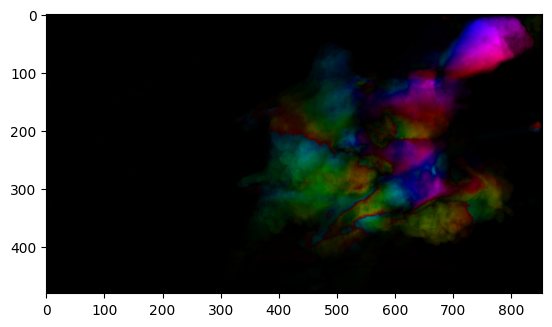

array([[[  0, 255,   0],
        [  0, 255,   0],
        [180, 255,   0],
        ...,
        [249, 255,   2],
        [244, 255,   1],
        [246, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 17, 255,   4],
        [  9, 255,   2],
        [ 13, 255,   1]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 29, 255,   5],
        [ 23, 255,   3],
        [ 29, 255,   1]],

       ...,

       [[ 80, 255,   1],
        [ 91, 255,   3],
        [ 96, 255,   4],
        ...,
        [ 47, 255,   0],
        [ 82, 255,   0],
        [120, 255,   0]],

       [[ 81, 255,   1],
        [ 91, 255,   2],
        [ 96, 255,   3],
        ...,
        [ 27, 255,   0],
        [ 90, 255,   0],
        [239, 255,   0]],

       [[ 83, 255,   0],
        [ 93, 255,   1],
        [100, 255,   1],
        ...,
        [ 83, 255,   0],
        [ 30, 255,   0],
        [  8, 255,   0]]

In [3]:

flow = count_flow('data/kick.mp4', frames_to_skip=5, verbose=False)
visualize_flow(flow)


[h264 @ 0x563d78dd1f80] mmco: unref short failure
[h264 @ 0x563d78dd1f80] mmco: unref short failure


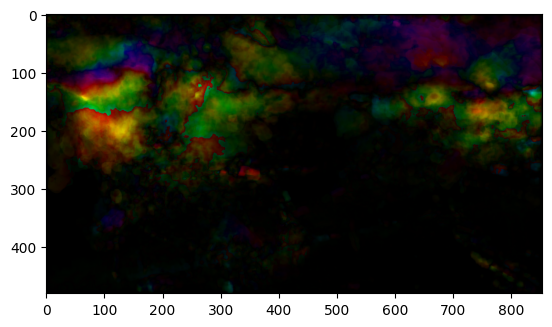

In [44]:
flow = count_flow('data/back.mp4', frames_to_skip=0, verbose=False)
visualize_flow(flow)


#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

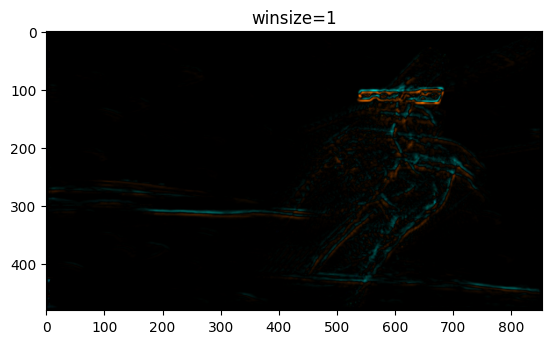

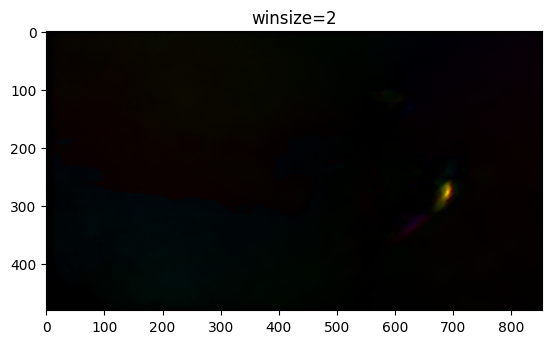

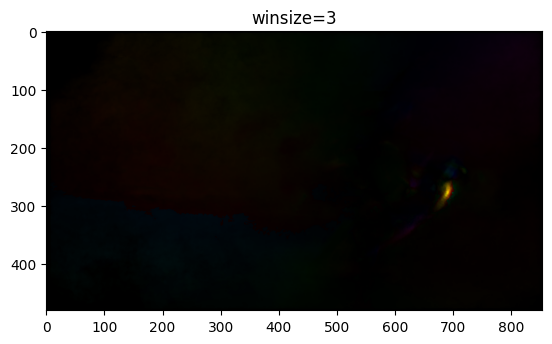

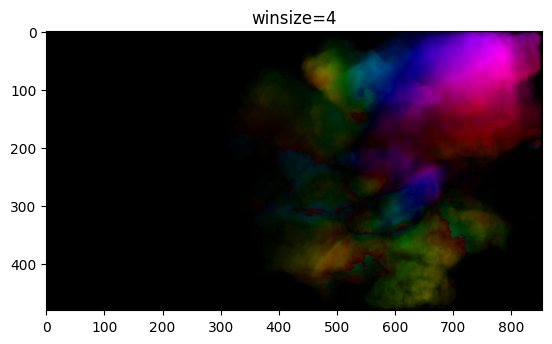

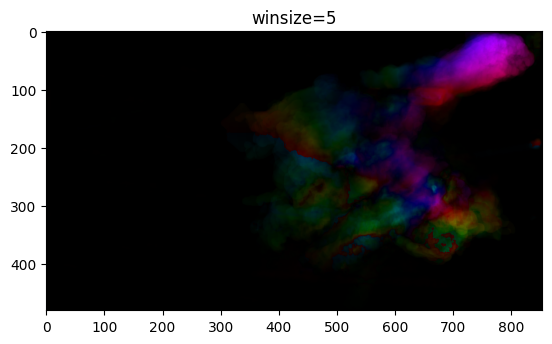

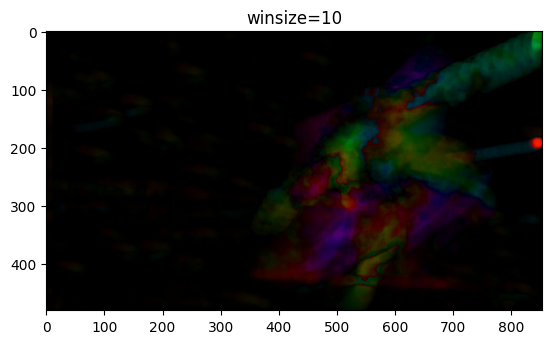

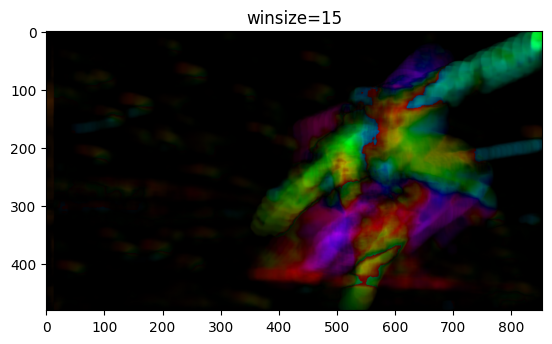

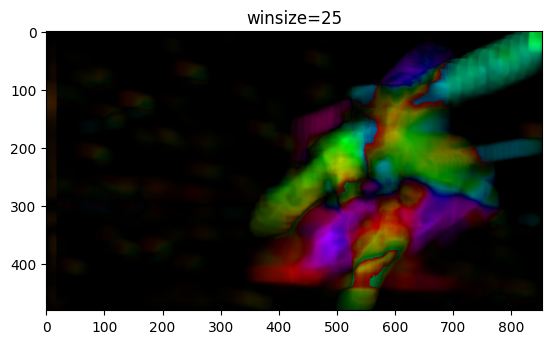

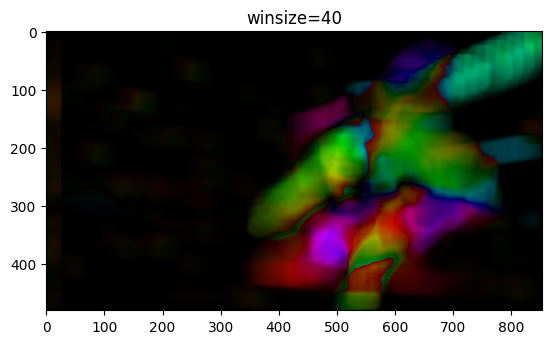

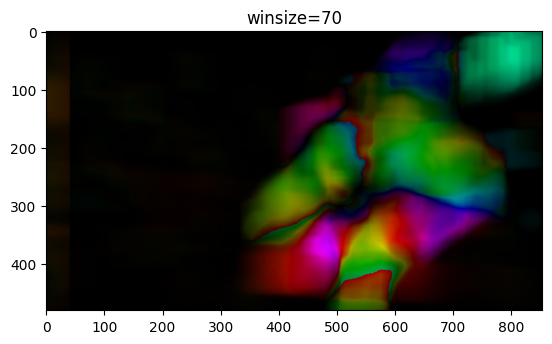

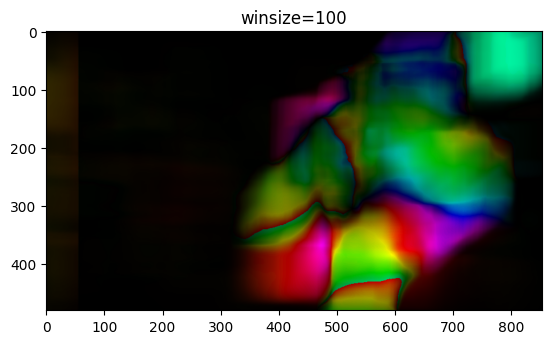

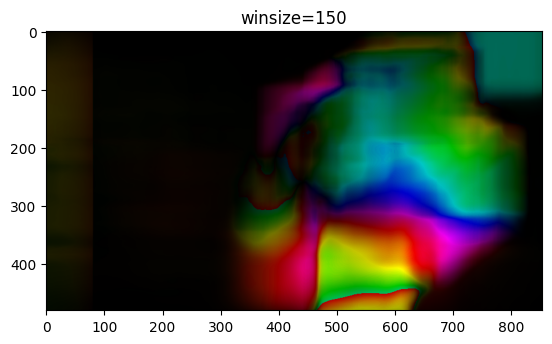

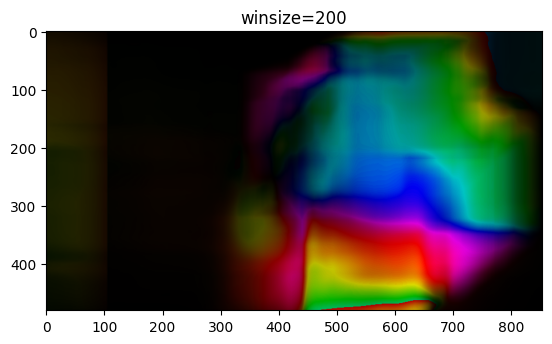

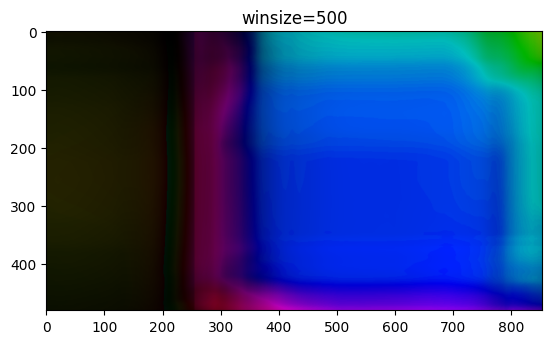

In [75]:
for winsize in [1, 2, 3, 4, 5, 10, 15, 25, 40, 70, 100, 150, 200, 500]: 
    flow = count_flow('data/kick.mp4', frames_to_skip=15, verbose=False, win_size=winsize)
    visualize_flow(flow, title=f'winsize={winsize}')


[h264 @ 0x563d7978a440] mmco: unref short failure
[h264 @ 0x563d7978a440] mmco: unref short failure


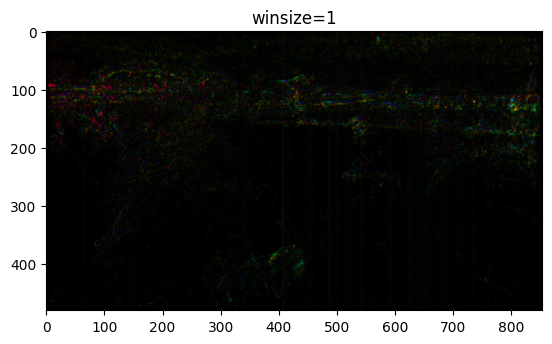

[h264 @ 0x563d78797dc0] mmco: unref short failure
[h264 @ 0x563d78797dc0] mmco: unref short failure


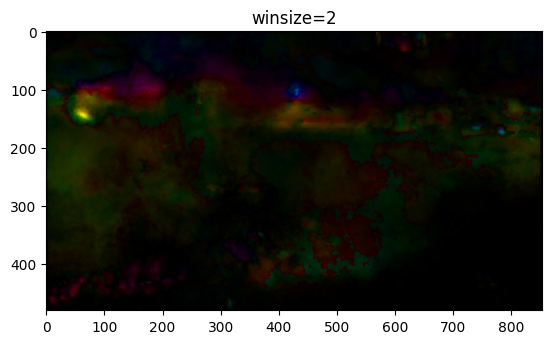

[h264 @ 0x563d818e8b00] mmco: unref short failure
[h264 @ 0x563d818e8b00] mmco: unref short failure


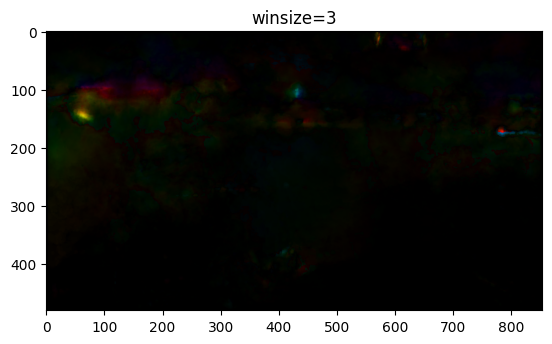

[h264 @ 0x563d7a5969c0] mmco: unref short failure
[h264 @ 0x563d7a5969c0] mmco: unref short failure


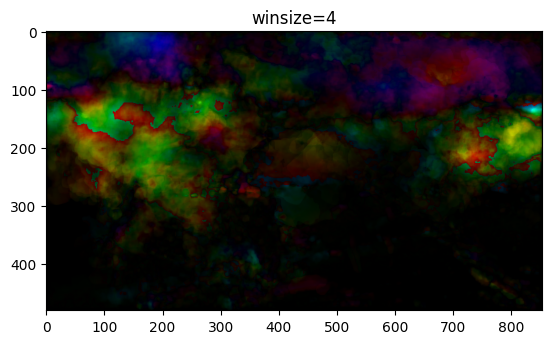

[h264 @ 0x563d818e92c0] mmco: unref short failure
[h264 @ 0x563d818e92c0] mmco: unref short failure


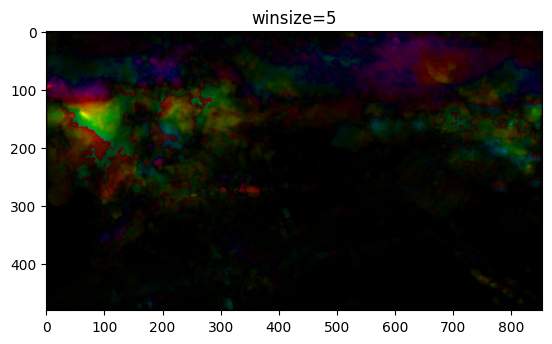

[h264 @ 0x563d77ee9600] mmco: unref short failure
[h264 @ 0x563d77ee9600] mmco: unref short failure


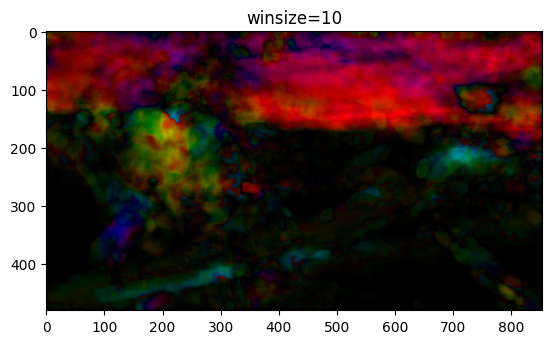

[h264 @ 0x563d77f4f400] mmco: unref short failure
[h264 @ 0x563d77f4f400] mmco: unref short failure


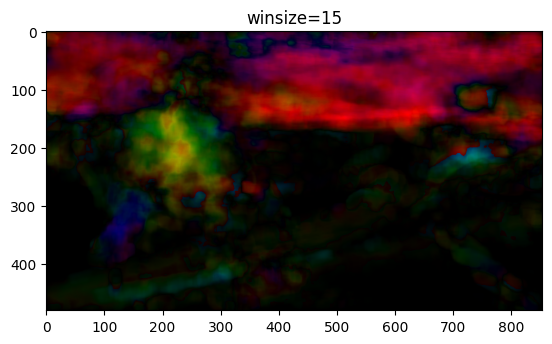

[h264 @ 0x563d77f4cd40] mmco: unref short failure
[h264 @ 0x563d77f4cd40] mmco: unref short failure


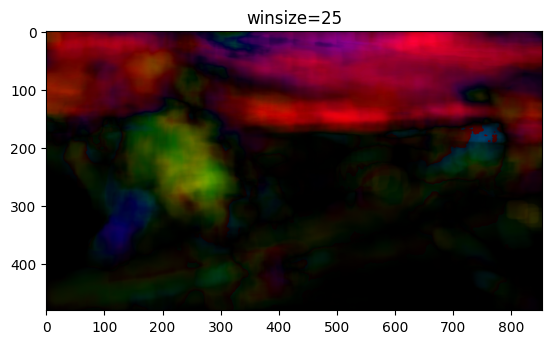

[h264 @ 0x563d7a5b2e00] mmco: unref short failure
[h264 @ 0x563d7a5b2e00] mmco: unref short failure


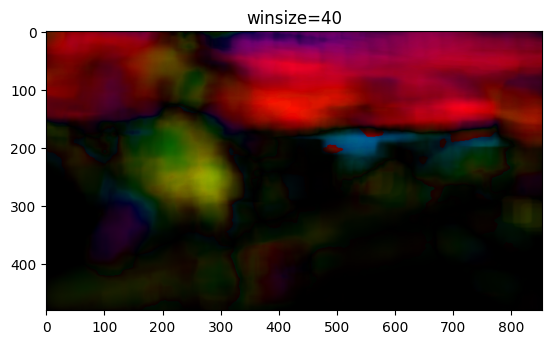

[h264 @ 0x563d798b6880] mmco: unref short failure
[h264 @ 0x563d798b6880] mmco: unref short failure


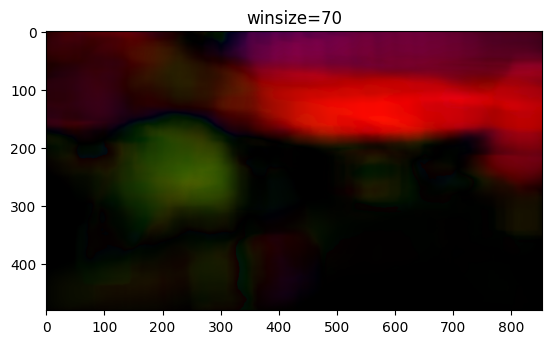

[h264 @ 0x563d81920b00] mmco: unref short failure
[h264 @ 0x563d81920b00] mmco: unref short failure


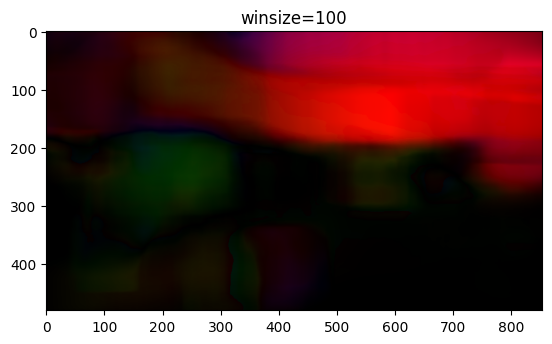

[h264 @ 0x563d798c60c0] mmco: unref short failure
[h264 @ 0x563d798c60c0] mmco: unref short failure


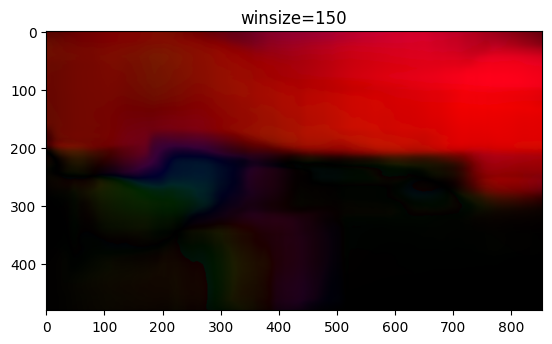

[h264 @ 0x563d794f1600] mmco: unref short failure
[h264 @ 0x563d794f1600] mmco: unref short failure


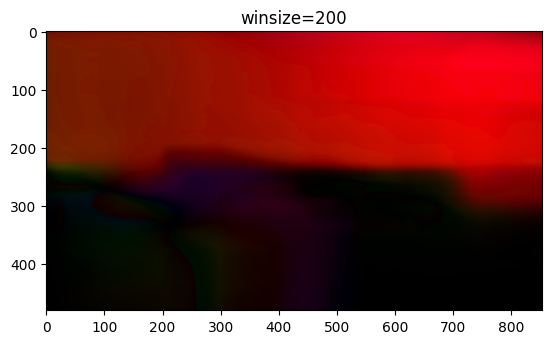

[h264 @ 0x563d7ac61100] mmco: unref short failure
[h264 @ 0x563d7ac61100] mmco: unref short failure


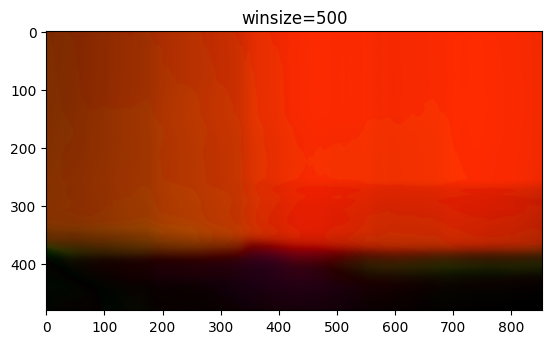

In [76]:
for winsize in [1, 2, 3, 4, 5, 10, 15, 25, 40, 70, 100, 150, 200, 500]:
    flow = count_flow('data/back.mp4', frames_to_skip=15, verbose=False, win_size=winsize)
    visualize_flow(flow, title=f'winsize={winsize}')

Komentarz 1:

Minimalny winsize nie wykrywa kontekstu ruchu, a sam ruch pikseli, przez co obraz jest dość przypadkowy. Większe wartości pokazują ruch w kontekście obieku. Zbyt duże powodują zlewanie się obiektów. Większe wartości w kick pozwoliły też złapać ruchy mniej wyraźnych obiektów - plam na trawie. Wpływ szybkości ruchu i rozmiaru okna widać w zadaniu 2.

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*W czym leży trudność? Co jest ograniczeniem metody?*

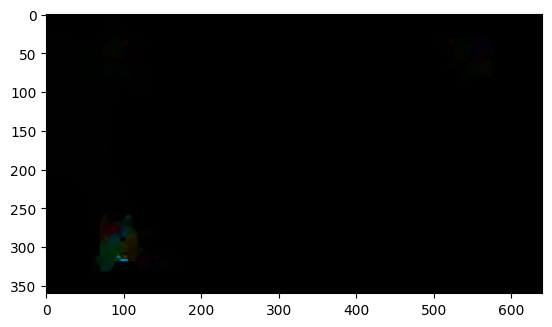

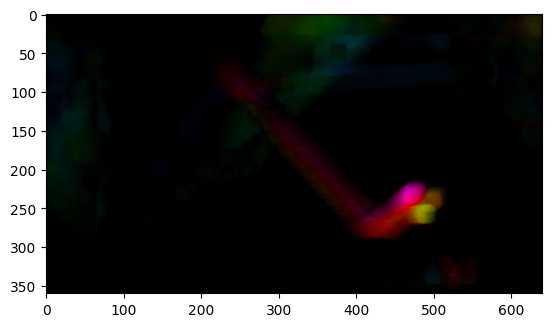

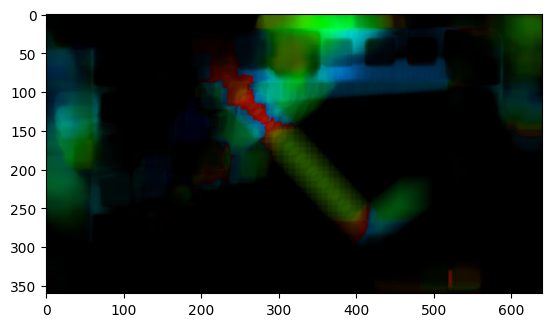

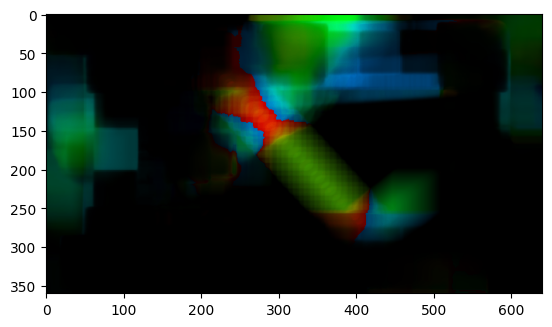

In [70]:
flow = count_flow('data/shot.mp4', frames_to_skip=20, verbose=False, win_size=5)
visualize_flow(flow)

flow = count_flow('data/shot.mp4', frames_to_skip=20, verbose=False, win_size=15)
visualize_flow(flow)

flow = count_flow('data/shot.mp4', frames_to_skip=20, verbose=False, win_size=30)
visualize_flow(flow)

flow = count_flow('data/shot.mp4', frames_to_skip=20, verbose=False, win_size=50)
visualize_flow(flow)

Komentarz 2:

Szybki ruch bili jest trudny do złapania - jest rozmazana i mało wyraźna na kolejnych klatkach. Dużo łatwiej złapać zakłócenia, takie jak ruch zawodników. Zwiększenie okna nie poprawia działania, gdyż algorytm łapie przede wszystkich ruch zawodników i traci na precyzji lokalizacji ruchu.

### Zadanie 3

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).

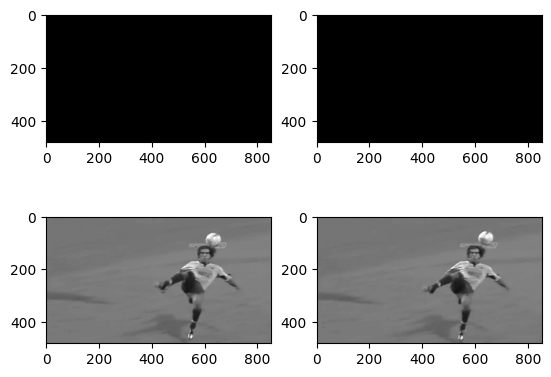

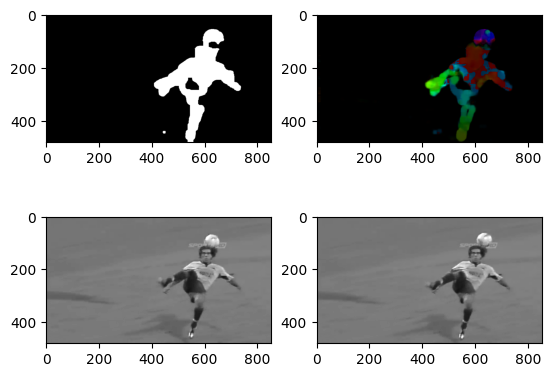

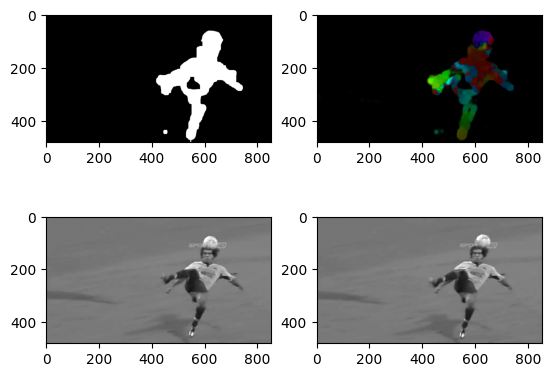

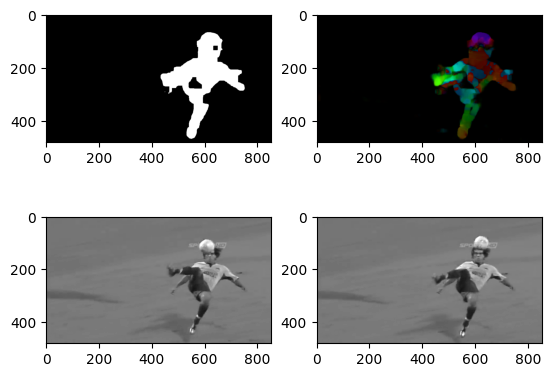

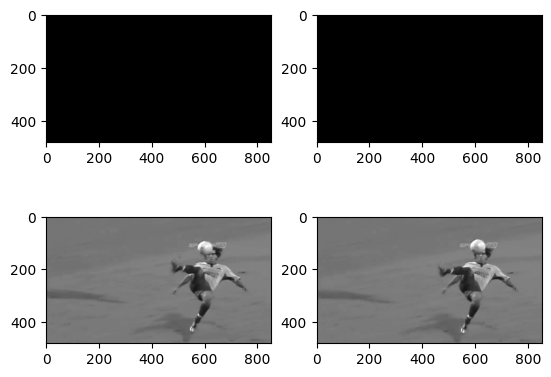

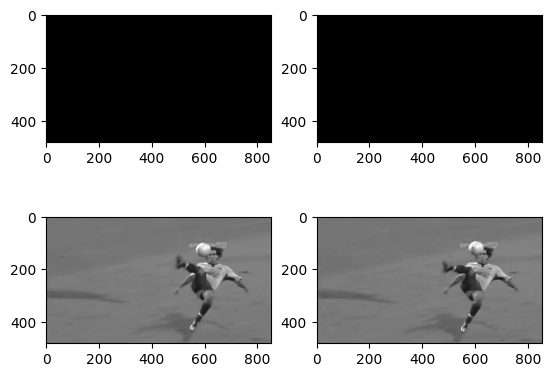

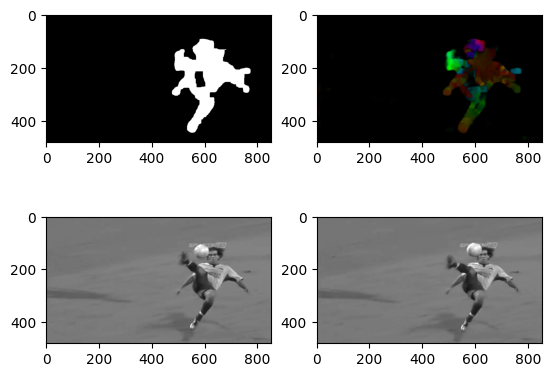

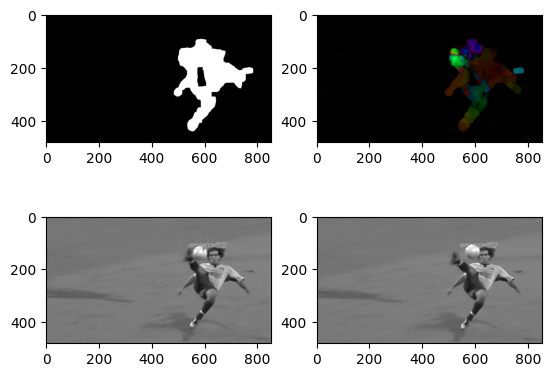

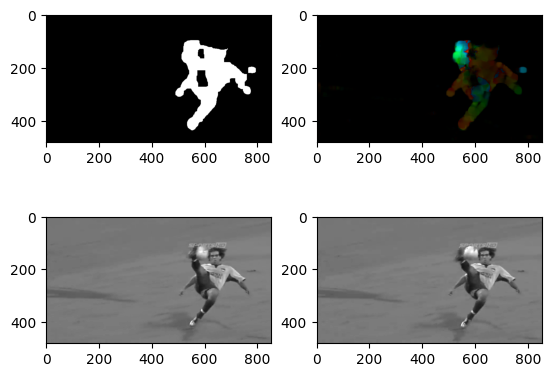

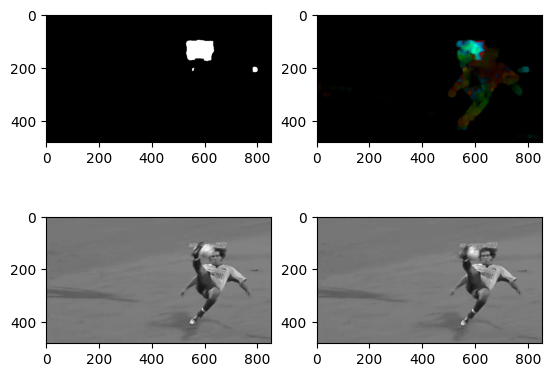

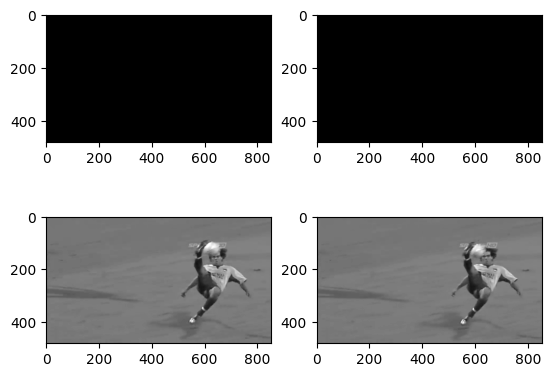

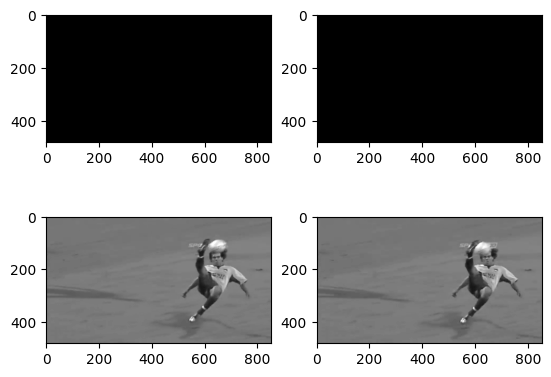

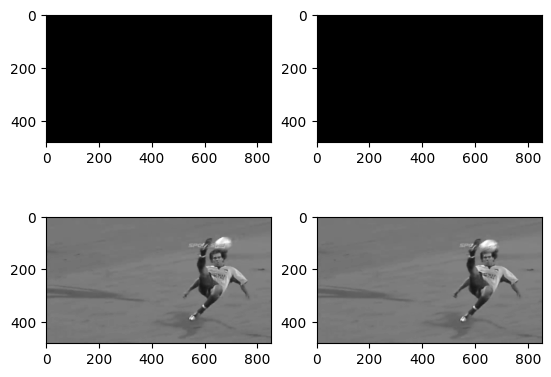

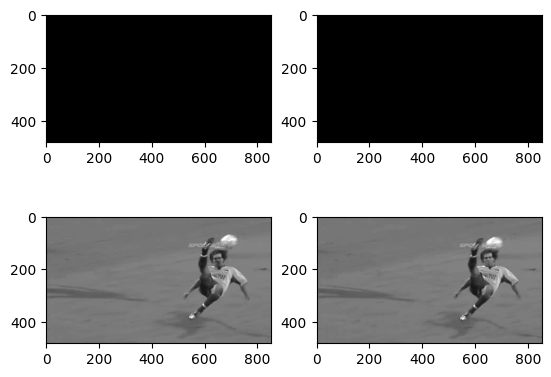

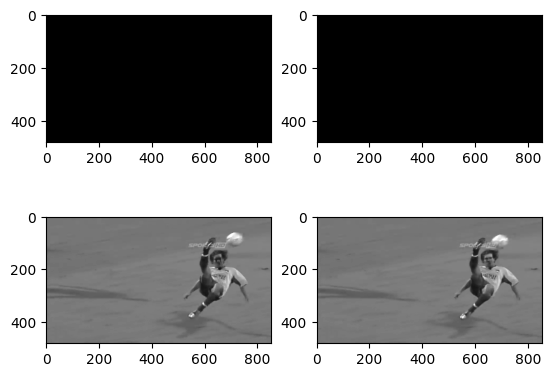

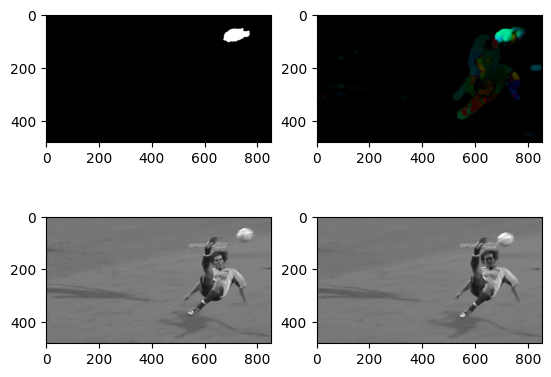

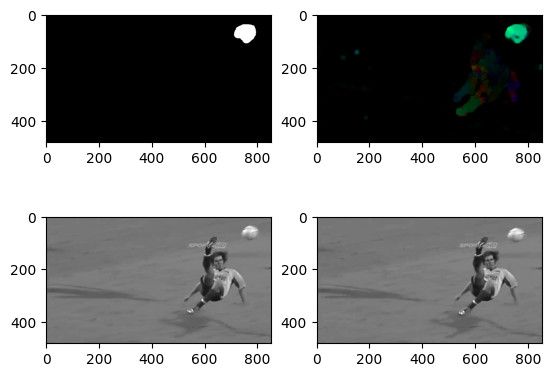

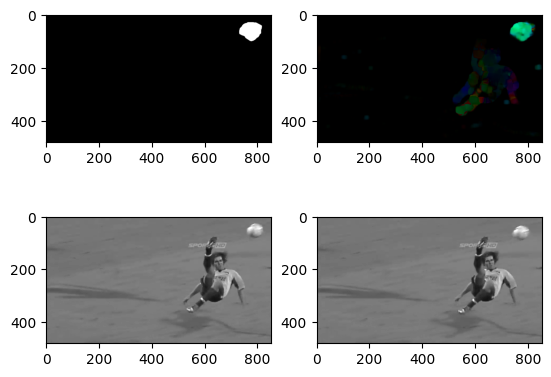

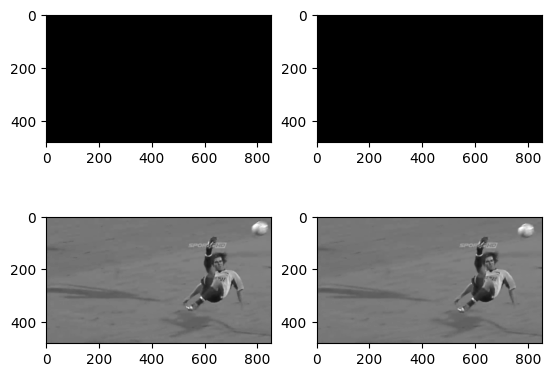

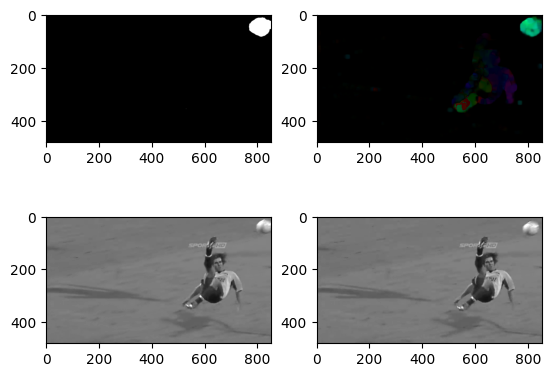

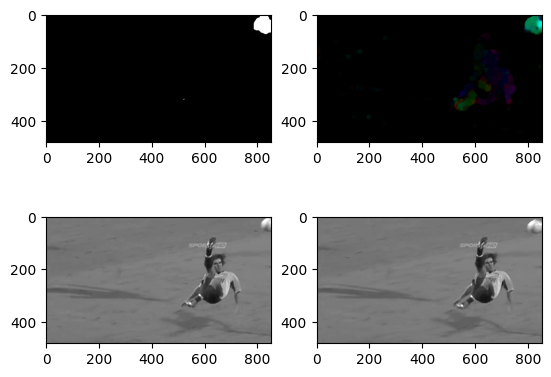

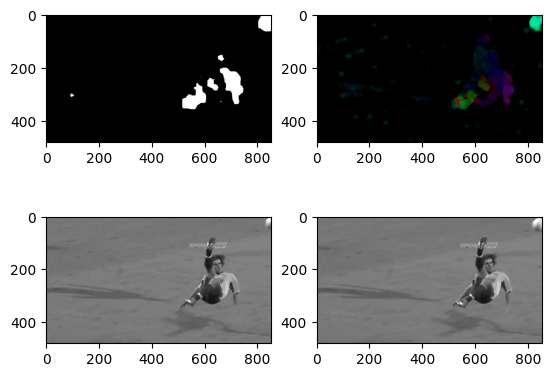

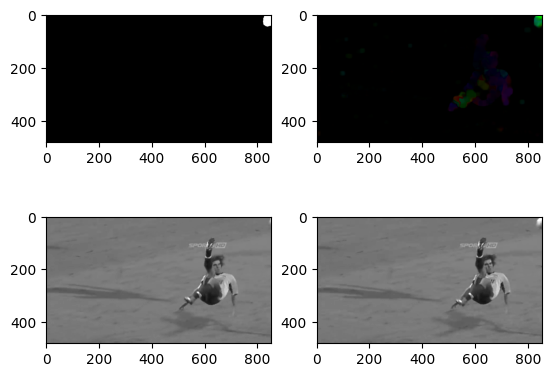

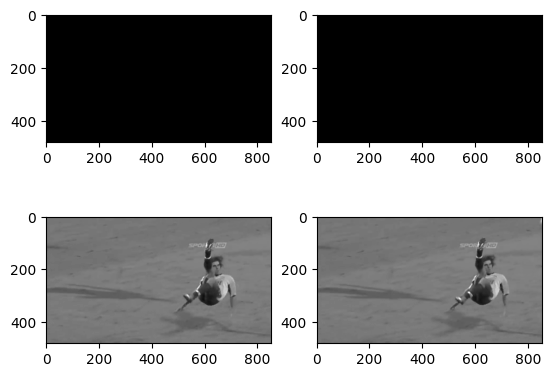

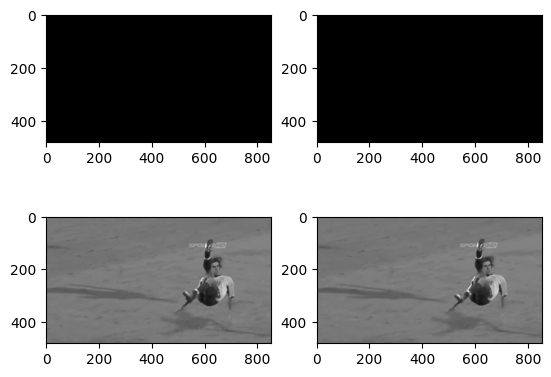

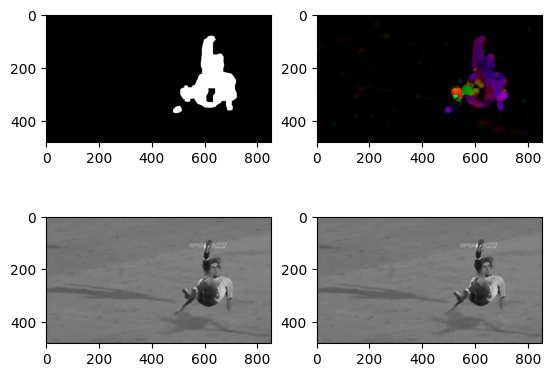

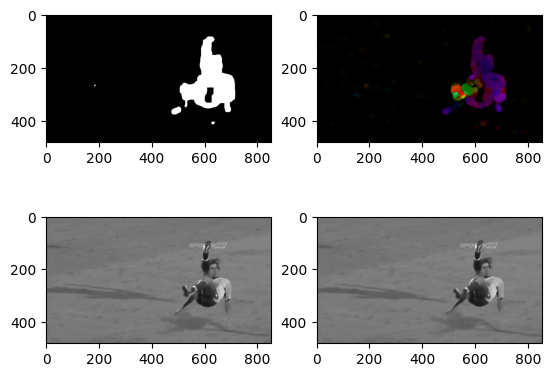

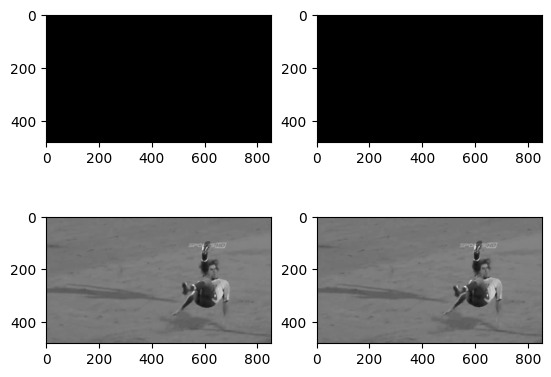

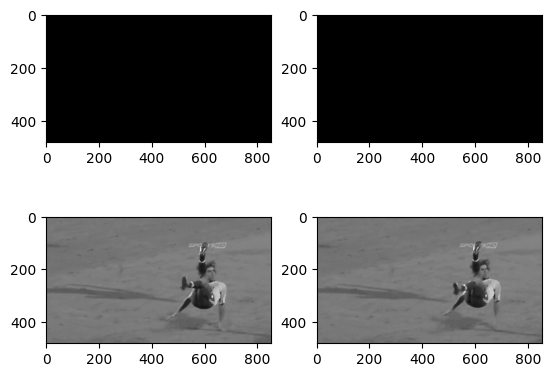

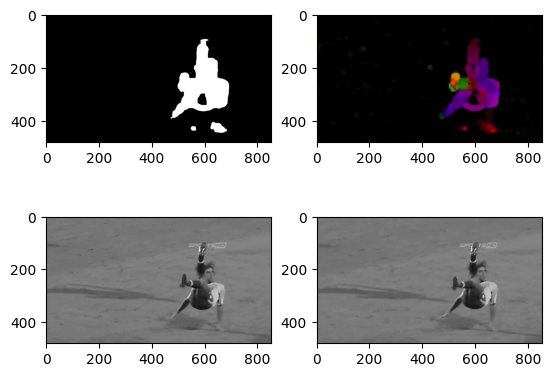

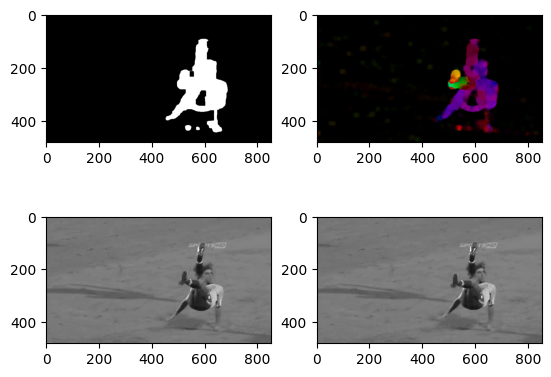

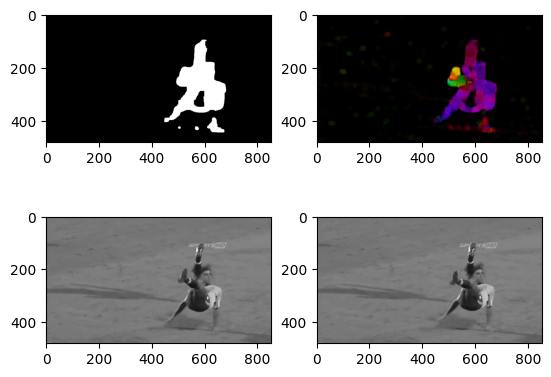

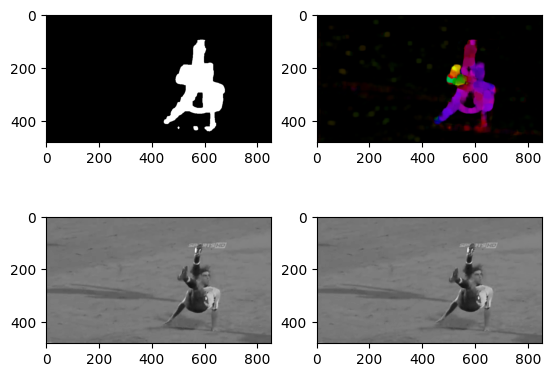

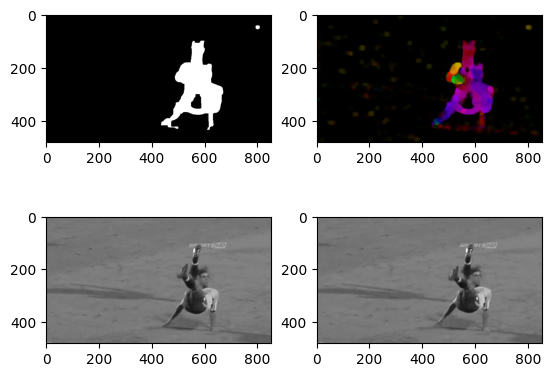

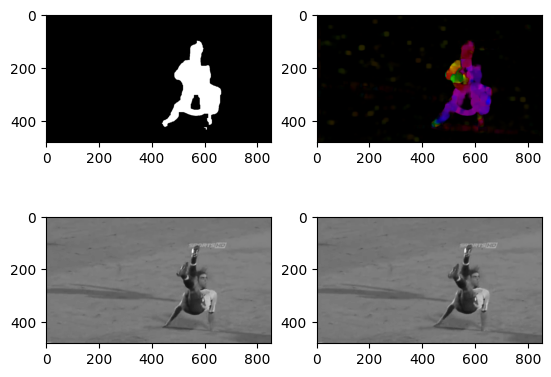

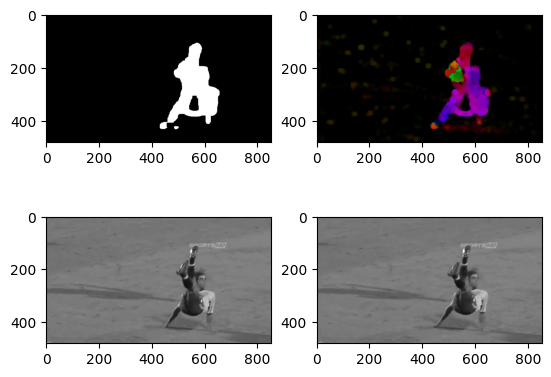

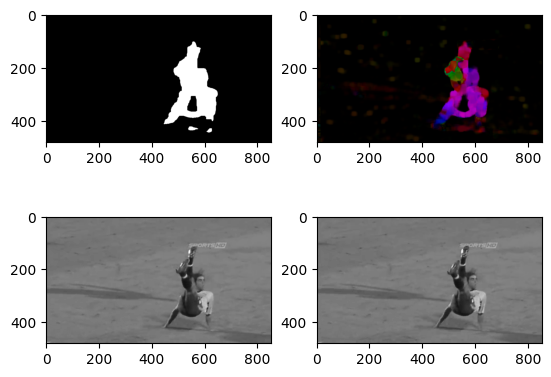

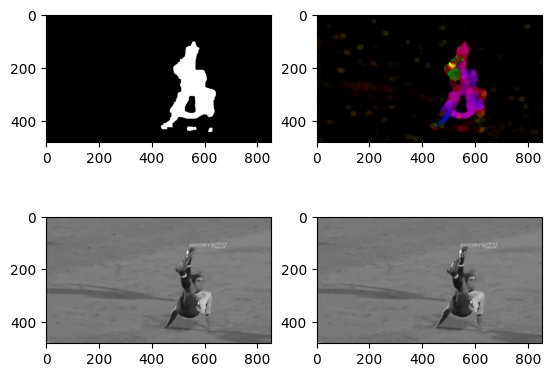

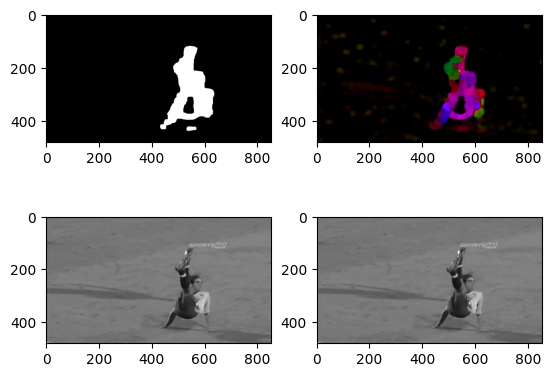

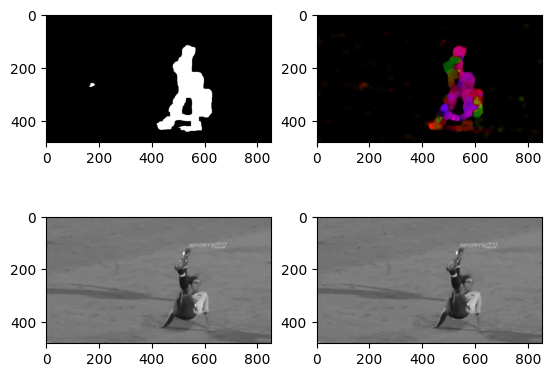

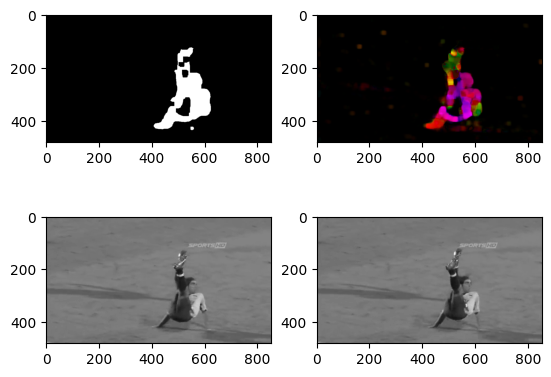

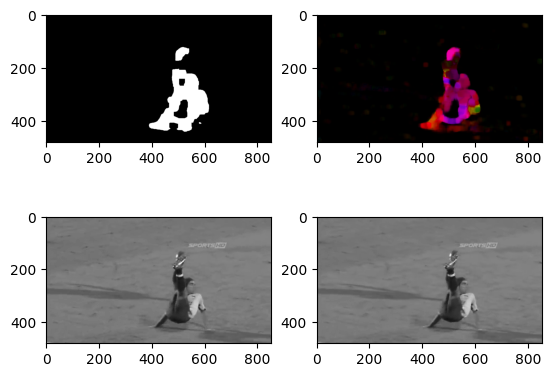

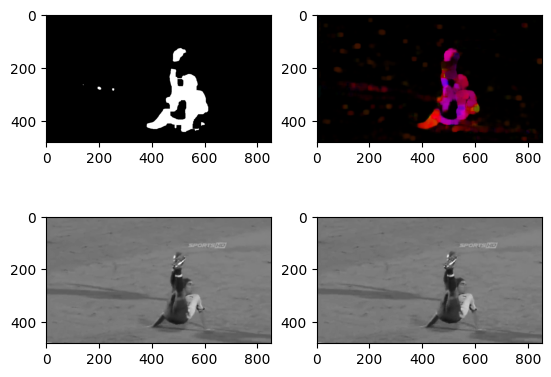

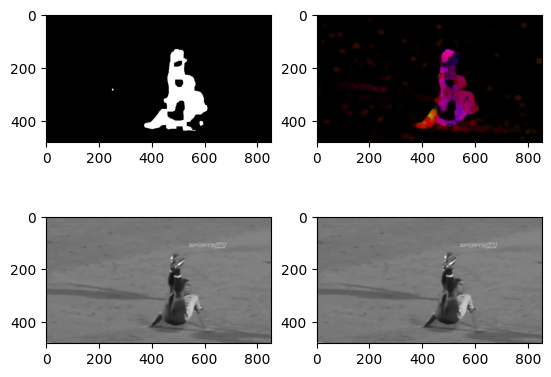

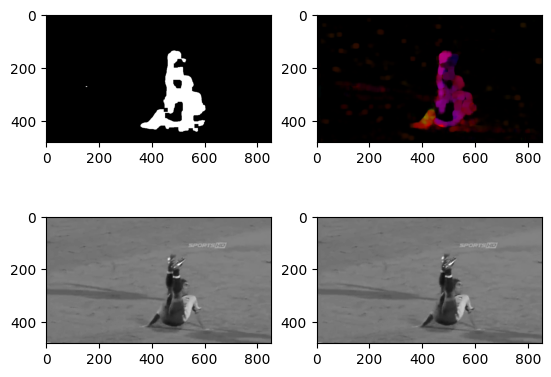

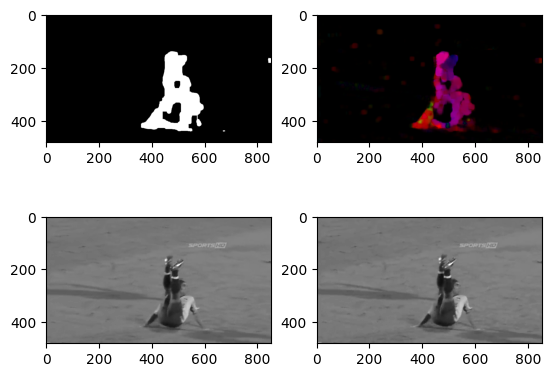

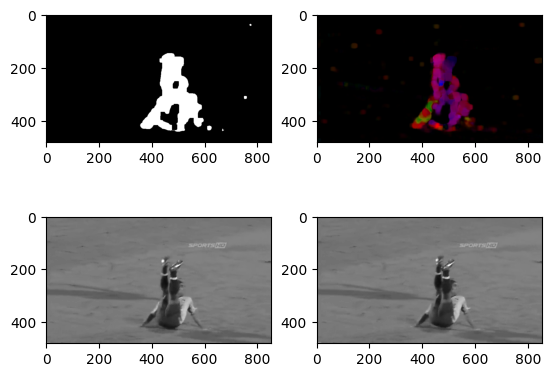

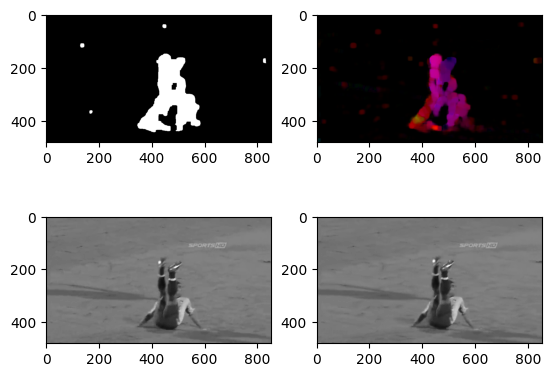

In [5]:
def calc_flow_segmentation(source, frames_to_skip=10, verbose=True, win_size=5):
    movie = VideoCaptureIterator(source, frames_to_skip)
    flow_calc = FlowCalc(movie, win_size)


    for frame in movie:
        flow_calc.calc()
        img = make_visualization_img(flow_calc.flow)
        _, th_img = cv2.threshold(img[..., 2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
        th_img = cv2.morphologyEx(th_img, op=cv2.MORPH_CLOSE, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
        if verbose == True or verbose == 'seg':
            _, (ax1, ax2) = plt.subplots(nrows=2, ncols=2)
            ax1[0].imshow(th_img, cmap='gray')
            ax1[1].imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))
            ax2[0].imshow(movie.next, cmap='gray')
            ax2[1].imshow(movie.prev, cmap='gray')
            plt.show()
        if verbose == True or verbose == 'hsv':
            visualize_flow(flow_calc.flow)

calc_flow_segmentation('data/kick.mp4', verbose='seg', frames_to_skip=20, win_size=15)